## Comparing Initialization Methods in Grammatical Evolution
# 
## This experiment compares three population initialization strategies:
## 1.  Random Initialization - Baseline random genome generation
## 2.  Sensible Initialization - Grammar-guided tree construction (Ryan & Azad, 2003)
## 3.  PI-Grow Initialization - Position Independent tree growth (Fagan et al., 2016)

## 1. Setup and Configuration

In [6]:
# %%
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
from scipy.stats import entropy, mannwhitneyu, kruskal
from sklearn.datasets import load_diabetes, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import time
from datetime import datetime
from typing import Dict, List, Tuple, Callable, Optional
from dataclasses import dataclass, field

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("=" * 70)
print(" GRAMMATICAL EVOLUTION: INITIALIZATION METHODS COMPARISON")
print("=" * 70)
print(f"\nExperiment timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Random seed: {SEED}")

 GRAMMATICAL EVOLUTION: INITIALIZATION METHODS COMPARISON

Experiment timestamp: 2026-01-28 12:20:40
Random seed: 42


In [7]:
# %%
# =============================================================================
# VISUALIZATION SETTINGS
# =============================================================================

plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'axes.titleweight': 'bold',
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
})

# Color palette - colorblind-friendly (Wong, 2011)
COLORS = {
    'Random': '#E69F00',     # Orange
    'Sensible': '#56B4E9',   # Sky Blue  
    'PI-Grow': '#009E73',    # Bluish Green
}

MARKERS = {
    'Random': 'o',
    'Sensible': 's',
    'PI-Grow': '^',
}

print("\nVisualization configuration:")
for method, color in COLORS.items():
    print(f"   {method:12s}: {color} ({MARKERS[method]})")


Visualization configuration:
   Random      : #E69F00 (o)
   Sensible    : #56B4E9 (s)
   PI-Grow     : #009E73 (^)


### 2. Experiment Configuration

In [9]:
# =============================================================================
# EXPERIMENT PARAMETERS (Dataclass for clean configuration)
# =============================================================================

@dataclass
class ExperimentConfig:
    """Configuration parameters for the GE experiment."""
    # Evolution parameters
    n_runs: int = 30              # Independent runs per method
    generations: int = 50         # Generations per run
    pop_size: int = 100           # Population size
    elite_size: int = 5           # Elitism count
    
    # GE parameters
    genome_length: int = 100      # Fixed genome length
    max_depth: int = 8            # Maximum derivation tree depth
    max_wraps: int = 2            # Maximum genome wraps
    codon_range: int = 256        # Codon value range [0, 256)
    
    # Genetic operators
    tournament_size: int = 3      # Tournament selection size
    crossover_rate: float = 0.9   # Crossover probability
    mutation_rate: float = 0.01   # Per-codon mutation probability
    
    # Problem settings
    train_ratio: float = 0.7      # Training data proportion
    
    def __post_init__(self):
        """Validate configuration."""
        assert 0 < self.crossover_rate <= 1.0
        assert 0 < self.mutation_rate <= 1.0
        assert self.elite_size < self.pop_size


# Create default configuration
CONFIG = ExperimentConfig()

print("\nExperiment Configuration:")
print("-" * 40)
for field_name, field_value in vars(CONFIG).items():
    print(f"   {field_name:20s}: {field_value}")


Experiment Configuration:
----------------------------------------
   n_runs              : 30
   generations         : 50
   pop_size            : 100
   elite_size          : 5
   genome_length       : 100
   max_depth           : 8
   max_wraps           : 2
   codon_range         : 256
   tournament_size     : 3
   crossover_rate      : 0.9
   mutation_rate       : 0.01
   train_ratio         : 0.7


### 3. Grammar Definition

In [12]:
# %%
# =============================================================================
# BNF GRAMMAR CLASS
# =============================================================================

class BNFGrammar:
    """
    BNF Grammar for Grammatical Evolution.
    
    - Non-terminals enclosed in angle brackets: <symbol>
    - Productions separated by pipe: |
    - Start symbol is first non-terminal defined
    
    Attributes:
        rules: OrderedDict mapping non-terminals to production lists
        start_symbol: Starting non-terminal for derivation
        non_terminals: List of all non-terminal symbols
        terminals: Set of all terminal symbols
    """
    
    def __init__(self, grammar_dict: Dict[str, List[List[str]]], 
                 start_symbol: str = None):
        """
        Initialize grammar from dictionary.
        
        Args:
            grammar_dict: Maps non-terminals to list of productions
            start_symbol: Override start symbol (default: first key)
        """
        self.rules = OrderedDict(grammar_dict)
        self.non_terminals = list(self.rules.keys())
        self.start_symbol = start_symbol or self.non_terminals[0]
        self.terminals = self._find_terminals()
        self._precompute_rule_info()
    
    def _find_terminals(self) -> set:
        """Identify all terminal symbols in the grammar."""
        terminals = set()
        for productions in self.rules.values():
            for prod in productions:
                for symbol in prod:
                    if not self._is_non_terminal(symbol):
                        terminals.add(symbol)
        return terminals
    
    def _precompute_rule_info(self):
        """Precompute useful information about rules for efficiency."""
        self.terminal_rule_indices = {}
        self.recursive_rule_indices = {}
        
        for nt, productions in self.rules.items():
            self.terminal_rule_indices[nt] = [
                i for i, prod in enumerate(productions)
                if not any(self._is_non_terminal(s) for s in prod)
            ]
            self.recursive_rule_indices[nt] = [
                i for i, prod in enumerate(productions)
                if any(self._is_non_terminal(s) for s in prod)
            ]
    
    @staticmethod
    def _is_non_terminal(symbol: str) -> bool:
        """Check if symbol is a non-terminal (enclosed in angle brackets)."""
        return symbol.startswith('<') and symbol.endswith('>')
    
    def get_production(self, non_terminal: str, codon: int) -> List[str]:
        """Select production using codon value."""
        productions = self.rules[non_terminal]
        return productions[codon % len(productions)]
    
    def num_productions(self, non_terminal: str) -> int:
        """Return number of productions for a non-terminal."""
        return len(self.rules[non_terminal])
    
    def has_terminal_production(self, non_terminal: str) -> bool:
        """Check if non-terminal has at least one terminal production."""
        return len(self.terminal_rule_indices[non_terminal]) > 0
    
    def __str__(self) -> str:
        """Return BNF string representation."""
        lines = []
        for nt, productions in self.rules.items():
            prods_str = ' | '.join([''.join(p) for p in productions])
            lines.append(f"{nt} ::= {prods_str}")
        return '\n'.join(lines)
    
    def __repr__(self) -> str:
        return f"BNFGrammar(start='{self.start_symbol}', rules={len(self.rules)})"


print("BNFGrammar class defined!")


BNFGrammar class defined!


In [13]:
# %%
# =============================================================================
# GRAMMAR DEFINITIONS FOR SYMBOLIC REGRESSION
# =============================================================================

# Standard Symbolic Regression Grammar
SR_GRAMMAR = BNFGrammar({
    '<expr>': [
        ['<expr>', '<op>', '<expr>'],      # Binary operation
        ['<pre_op>', '(', '<expr>', ')'],  # Unary function
        ['<var>'],                          # Variable
        ['<const>']                         # Constant
    ],
    '<op>': [['+'], ['-'], ['*'], ['pdiv']],  # Protected division
    '<pre_op>': [['np.sin'], ['np.cos'], ['np.log1p'], ['np.sqrt']],
    '<var>': [['x[:, 0]']],  # Will be extended per problem
    '<const>': [['1.0'], ['2.0'], ['0.5'], ['0.1'], ['np.pi']]
})

def create_sr_grammar(n_features: int) -> BNFGrammar:
    """
    Create a symbolic regression grammar for n features.
    
    Args:
        n_features: Number of input features
    
    Returns:
        BNFGrammar configured for the problem
    """
    var_rules = [[f'x[:, {i}]'] for i in range(n_features)]
    
    return BNFGrammar({
        '<expr>': [
            ['(', '<expr>', '<op>', '<expr>', ')'],
            ['<pre_op>', '(', '<expr>', ')'],
            ['<var>'],
            ['<const>']
        ],
        '<op>': [['+'], ['-'], ['*'], ['pdiv']],
        '<pre_op>': [['np.sin'], ['np.cos'], ['np.log1p'], ['np.sqrt'], ['np.abs']],
        '<var>': var_rules,
        '<const>': [['1.0'], ['2.0'], ['0.5'], ['0.1'], ['np.pi'], ['np.e']]
    })


print("\nSymbolic Regression Grammar:")
print("-" * 50)
print(SR_GRAMMAR)



Symbolic Regression Grammar:
--------------------------------------------------
<expr> ::= <expr><op><expr> | <pre_op>(<expr>) | <var> | <const>
<op> ::= + | - | * | pdiv
<pre_op> ::= np.sin | np.cos | np.log1p | np.sqrt
<var> ::= x[:, 0]
<const> ::= 1.0 | 2.0 | 0.5 | 0.1 | np.pi


### 4. Core GE Components

In [15]:
# %%
# =============================================================================
# INDIVIDUAL REPRESENTATION
# =============================================================================

@dataclass
class Individual:
    """
    Represents a candidate solution in Grammatical Evolution.
    
    Attributes:
        genome: List of integer codons encoding the solution
        phenotype: Derived program string (None if not yet mapped)
        fitness: Fitness value (infinity if invalid/unevaluated)
        valid: Whether genome maps to valid phenotype
        depth: Maximum depth of derivation tree
        used_codons: Number of codons used in mapping
    """
    genome: List[int] = field(default_factory=list)
    phenotype: Optional[str] = None
    fitness: float = float('inf')
    valid: bool = False
    depth: int = 0
    used_codons: int = 0
    
    def __post_init__(self):
        """Convert genome to tuple for hashability if needed."""
        if isinstance(self.genome, tuple):
            self.genome = list(self.genome)
    
    def copy(self) -> 'Individual':
        """Create a deep copy of the individual."""
        return Individual(
            genome=self.genome.copy(),
            phenotype=self.phenotype,
            fitness=self.fitness,
            valid=self.valid,
            depth=self.depth,
            used_codons=self.used_codons
        )
    
    def __repr__(self) -> str:
        status = "✓" if self.valid else "✗"
        return f"Individual({status}, fitness={self.fitness:.4f})"


print("Individual class defined!")

Individual class defined!


In [16]:
# %%
# =============================================================================
# GENOTYPE-PHENOTYPE MAPPER
# =============================================================================

class GEMapper:
    """
    Maps integer genomes to phenotypes using a BNF grammar.
    
    Implements the standard GE mapping with:
    - Depth-first leftmost derivation
    - Genome wrapping for long derivations
    - Memoization for efficiency
    """
    
    def __init__(self, grammar: BNFGrammar, max_depth: int = 10, max_wraps: int = 2):
        """
        Initialize the mapper.
        
        Args:
            grammar: BNF grammar for mapping
            max_depth: Maximum derivation tree depth
            max_wraps: Maximum times to wrap around genome
        """
        self.grammar = grammar
        self.max_depth = max_depth
        self.max_wraps = max_wraps
        self.cache = {}
    
    def map(self, individual: Individual) -> bool:
        """
        Map genome to phenotype using grammar derivation.
        
        Args:
            individual: Individual to map (modified in place)
        
        Returns:
            True if mapping successful, False otherwise
        """
        genome_tuple = tuple(individual.genome)
        
        # Check cache
        if genome_tuple in self.cache:
            cached = self.cache[genome_tuple]
            if cached is None:
                individual.valid = False
                return False
            individual.phenotype, individual.depth, individual.used_codons = cached
            individual.valid = True
            return True
        
        # Perform mapping
        result = self._derive(individual.genome)
        
        if result is None:
            self.cache[genome_tuple] = None
            individual.valid = False
            return False
        
        phenotype, depth, used_codons = result
        self.cache[genome_tuple] = result
        
        individual.phenotype = phenotype
        individual.depth = depth
        individual.used_codons = used_codons
        individual.valid = True
        return True
    
    def _derive(self, genome: List[int]) -> Optional[Tuple[str, int, int]]:
        """
        Perform grammar derivation.
        
        Returns:
            Tuple of (phenotype, depth, used_codons) or None if failed
        """
        if not genome:
            return None
        
        phenotype_parts = []
        stack = [(self.grammar.start_symbol, 0)]  # (symbol, depth)
        codon_idx = 0
        genome_len = len(genome)
        max_depth = 0
        wraps = 0
        
        try:
            while stack:
                symbol, depth = stack.pop()
                max_depth = max(max_depth, depth)
                
                # Check depth limit
                if depth > self.max_depth:
                    return None
                
                # Process symbol
                if self.grammar._is_non_terminal(symbol):
                    if symbol not in self.grammar.rules:
                        phenotype_parts.append(symbol)
                        continue
                    
                    # Check wrapping
                    if codon_idx >= genome_len:
                        wraps += 1
                        if wraps > self.max_wraps:
                            return None
                    
                    # Select and apply production
                    codon = genome[codon_idx % genome_len]
                    codon_idx += 1
                    production = self.grammar.get_production(symbol, codon)
                    
                    # Push in reverse order for correct derivation
                    for s in reversed(production):
                        stack.append((s, depth + 1))
                else:
                    phenotype_parts.append(symbol)
            
            return ''.join(phenotype_parts), max_depth, codon_idx
            
        except Exception:
            return None
    
    def clear_cache(self):
        """Clear the memoization cache."""
        self.cache.clear()


print("GEMapper class defined!")

GEMapper class defined!


### 5. Initialization Methods

In [17]:
# %%
# =============================================================================
# INITIALIZATION METHOD 1: RANDOM
# =============================================================================

def random_init(pop_size: int, genome_length: int, 
                codon_range: int = 256, **kwargs) -> List[Individual]:
    """
    Random Initialization (Baseline).
    
    Generates random integer genomes without grammar consideration.
    Simple but may produce many invalid individuals.
    
    Args:
        pop_size: Number of individuals to create
        genome_length: Length of each genome
        codon_range: Range of codon values [0, codon_range)
    
    Returns:
        List of randomly initialized individuals
    """
    population = []
    for _ in range(pop_size):
        genome = [random.randint(0, codon_range - 1) for _ in range(genome_length)]
        population.append(Individual(genome=genome))
    return population


print("random_init() defined - Baseline random initialization")

# %%
# =============================================================================
# INITIALIZATION METHOD 2: SENSIBLE
# =============================================================================

def sensible_init(pop_size: int, genome_length: int, grammar: BNFGrammar,
                  max_depth: int = 6, codon_range: int = 256, **kwargs) -> List[Individual]:
    """
    Sensible Initialization.
    
    Creates individuals by grammar-guided derivation tree construction.
    Biases towards terminal productions when approaching target depth.
    Guarantees syntactically valid individuals.
   
    
    Args:
        pop_size: Number of individuals to create
        genome_length: Desired genome length (padded if needed)
        grammar: BNF grammar for derivation
        max_depth: Maximum tree depth target
        codon_range: Range of codon values
    
    Returns:
        List of sensibly initialized individuals
    """
    population = []
    
    for _ in range(pop_size):
        genome = []
        # Queue: (non-terminal, current_depth) - BFS order
        queue = [(grammar.start_symbol, 0)]
        target_depth = random.randint(2, max_depth)
        
        while queue:
            symbol, depth = queue.pop(0)  # FIFO for breadth-first
            
            if symbol not in grammar.rules:
                continue
            
            num_prods = grammar.num_productions(symbol)
            terminal_indices = grammar.terminal_rule_indices[symbol]
            
            # Select production: prefer terminals at/beyond target depth
            if depth >= target_depth and terminal_indices:
                rule_idx = random.choice(terminal_indices)
            else:
                rule_idx = random.randint(0, num_prods - 1)
            
            # Generate codon that maps to selected rule
            # Add randomness while preserving rule selection
            base = rule_idx
            multiplier = random.randint(0, (codon_range // num_prods) - 1)
            codon = base + multiplier * num_prods
            genome.append(codon % codon_range)
            
            # Queue non-terminals from chosen production
            production = grammar.rules[symbol][rule_idx]
            for s in production:
                if grammar._is_non_terminal(s):
                    queue.append((s, depth + 1))
        
        # Pad genome to fixed length
        while len(genome) < genome_length:
            genome.append(random.randint(0, codon_range - 1))
        
        population.append(Individual(genome=genome[:genome_length]))
    
    return population


print("sensible_init() defined - Grammar-guided initialization (Ryan & Azad, 2003)")

# %%
# =============================================================================
# INITIALIZATION METHOD 3: PI-GROW 
# =============================================================================

def pi_grow_init(pop_size: int, genome_length: int, grammar: BNFGrammar,
                 max_depth: int = 6, codon_range: int = 256, **kwargs) -> List[Individual]:
    """
    Position Independent Grow (PI-Grow) Initialization.
    
    Similar to Sensible but randomizes non-terminal expansion order.
    Provides more uniform exploration of the derivation tree space
    by avoiding the left-most derivation bias.
    
    Reference:
        Fagan, D., et al. (2016). Exploring position independent 
        initialisation in grammatical evolution. IEEE CEC, 5060-5067.
    
    Args:
        pop_size: Number of individuals to create
        genome_length: Desired genome length
        grammar: BNF grammar for derivation
        max_depth: Maximum tree depth
        codon_range: Range of codon values
    
    Returns:
        List of PI-Grow initialized individuals
    """
    population = []
    
    for _ in range(pop_size):
        genome = []
        # Queue of pending non-terminals: (symbol, depth)
        queue = [(grammar.start_symbol, 0)]
        
        while queue:
            # KEY DIFFERENCE: Shuffle queue for position independence
            random.shuffle(queue)
            symbol, depth = queue.pop(0)
            
            if symbol not in grammar.rules:
                continue
            
            num_prods = grammar.num_productions(symbol)
            
            # At max depth: prefer rules with minimum non-terminals
            if depth >= max_depth:
                # Find productions with fewest non-terminals
                min_nt_count = float('inf')
                best_indices = []
                
                for i, prod in enumerate(grammar.rules[symbol]):
                    nt_count = sum(1 for s in prod if grammar._is_non_terminal(s))
                    if nt_count < min_nt_count:
                        min_nt_count = nt_count
                        best_indices = [i]
                    elif nt_count == min_nt_count:
                        best_indices.append(i)
                
                rule_idx = random.choice(best_indices)
            else:
                rule_idx = random.randint(0, num_prods - 1)
            
            # Generate codon
            base = rule_idx
            multiplier = random.randint(0, (codon_range // num_prods) - 1)
            codon = base + multiplier * num_prods
            genome.append(codon % codon_range)
            
            # Queue non-terminals (order will be randomized next iteration)
            production = grammar.rules[symbol][rule_idx]
            for s in production:
                if grammar._is_non_terminal(s):
                    queue.append((s, depth + 1))
        
        # Pad genome
        while len(genome) < genome_length:
            genome.append(random.randint(0, codon_range - 1))
        
        population.append(Individual(genome=genome[:genome_length]))
    
    return population


print("pi_grow_init() defined - Position Independent initialization")

random_init() defined - Baseline random initialization
sensible_init() defined - Grammar-guided initialization (Ryan & Azad, 2003)
pi_grow_init() defined - Position Independent initialization


### 6. Genetic Operators

In [18]:
# %%
# =============================================================================
# SELECTION OPERATOR
# =============================================================================

def tournament_selection(population: List[Individual], 
                         tournament_size: int = 3) -> Individual:
    """
    Tournament Selection.
    
    Randomly samples k individuals and returns the fittest.
    
    Args:
        population: Population to select from
        tournament_size: Number of individuals in tournament
    
    Returns:
        Selected individual (copy)
    """
    tournament = random.sample(population, min(tournament_size, len(population)))
    winner = min(tournament, key=lambda ind: ind.fitness)
    return winner.copy()


print("tournament_selection() defined")

# %%
# =============================================================================
# CROSSOVER OPERATOR
# =============================================================================

def one_point_crossover(parent1: Individual, parent2: Individual,
                        crossover_rate: float = 0.9) -> Tuple[Individual, Individual]:
    """
    Single-Point Crossover.
    
    With probability crossover_rate, exchanges genetic material
    at a random crossover point.
    
    Args:
        parent1, parent2: Parent individuals
        crossover_rate: Probability of crossover
    
    Returns:
        Two offspring individuals
    """
    if random.random() > crossover_rate:
        return parent1.copy(), parent2.copy()
    
    # Select crossover point
    min_len = min(len(parent1.genome), len(parent2.genome))
    if min_len <= 1:
        return parent1.copy(), parent2.copy()
    
    point = random.randint(1, min_len - 1)
    
    # Create offspring
    child1_genome = parent1.genome[:point] + parent2.genome[point:]
    child2_genome = parent2.genome[:point] + parent1.genome[point:]
    
    return Individual(genome=child1_genome), Individual(genome=child2_genome)


print("one_point_crossover() defined")

# %%
# =============================================================================
# MUTATION OPERATOR
# =============================================================================

def point_mutation(individual: Individual, mutation_rate: float = 0.01,
                   codon_range: int = 256) -> Individual:
    """
    Point Mutation.
    
    Each codon has probability mutation_rate of being replaced
    with a random value.
    
    Args:
        individual: Individual to mutate
        mutation_rate: Per-codon mutation probability
        codon_range: Range of new codon values
    
    Returns:
        Mutated individual (new object)
    """
    new_genome = individual.genome.copy()
    
    for i in range(len(new_genome)):
        if random.random() < mutation_rate:
            new_genome[i] = random.randint(0, codon_range - 1)
    
    return Individual(genome=new_genome)


print("point_mutation() defined")

# %% [markdown]
# ## 7. Fitness Evaluation

# %%
# =============================================================================
# PROTECTED OPERATORS
# =============================================================================

def pdiv(a, b):
    """Protected division - returns 1 when dividing by zero."""
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(np.abs(b) > 1e-10, a / b, 1.0)
        return np.nan_to_num(result, nan=1.0, posinf=1e10, neginf=-1e10)


# Evaluation context with protected operators
EVAL_CONTEXT = {
    'np': np,
    'pdiv': pdiv,
    '__builtins__': {}
}


print("Protected operators defined (pdiv for safe division)")

# %%
# =============================================================================
# FITNESS FUNCTION
# =============================================================================

class FitnessEvaluator:
    """
    Evaluates phenotypes on regression problems.
    
    Uses RMSE (Root Mean Square Error) as fitness metric.
    Implements caching for efficiency.
    """
    
    def __init__(self, X: np.ndarray, y: np.ndarray):
        """
        Initialize evaluator with training data.
        
        Args:
            X: Feature matrix (n_samples, n_features)
            y: Target vector (n_samples,)
        """
        self.X = X
        self.y = y
        self.cache = {}
        self.eval_count = 0
    
    def evaluate(self, phenotype: str) -> float:
        """
        Evaluate a phenotype string.
        
        Args:
            phenotype: Program string to evaluate
        
        Returns:
            RMSE fitness (lower is better)
        """
        if phenotype is None:
            return float('inf')
        
        # Check cache
        if phenotype in self.cache:
            return self.cache[phenotype]
        
        self.eval_count += 1
        
        try:
            # Create evaluation context
            local_context = {'x': self.X}
            
            # Evaluate phenotype
            pred = eval(phenotype, EVAL_CONTEXT, local_context)
            
            # Handle scalar predictions
            if np.isscalar(pred):
                pred = np.full_like(self.y, pred)
            
            # Ensure correct shape
            pred = np.asarray(pred).flatten()
            if len(pred) != len(self.y):
                return float('inf')
            
            # Clip and sanitize
            pred = np.clip(pred, -1e10, 1e10)
            pred = np.nan_to_num(pred, nan=1e10, posinf=1e10, neginf=-1e10)
            
            # Calculate RMSE
            rmse = np.sqrt(np.mean((pred - self.y) ** 2))
            rmse = min(rmse, 1e10)
            
            self.cache[phenotype] = rmse
            return rmse
            
        except Exception:
            self.cache[phenotype] = float('inf')
            return float('inf')
    
    def evaluate_individual(self, individual: Individual, 
                           mapper: GEMapper) -> float:
        """
        Map and evaluate an individual.
        
        Args:
            individual: Individual to evaluate
            mapper: GE mapper for genotype-phenotype mapping
        
        Returns:
            Fitness value
        """
        if mapper.map(individual):
            individual.fitness = self.evaluate(individual.phenotype)
        else:
            individual.fitness = float('inf')
        return individual.fitness
    
    def clear_cache(self):
        """Clear evaluation cache."""
        self.cache.clear()
        self.eval_count = 0


print("FitnessEvaluator class defined")


tournament_selection() defined
one_point_crossover() defined
point_mutation() defined
Protected operators defined (pdiv for safe division)
FitnessEvaluator class defined


### 8. Evolutionary Algorithm

In [19]:
# %%
# =============================================================================
# MAIN EVOLUTIONARY ALGORITHM
# =============================================================================

@dataclass
class RunStatistics:
    """Statistics collected during an evolutionary run."""
    best_fitness: List[float] = field(default_factory=list)
    mean_fitness: List[float] = field(default_factory=list)
    validity_rate: List[float] = field(default_factory=list)
    diversity: List[float] = field(default_factory=list)
    best_phenotype: List[str] = field(default_factory=list)


def run_evolution(
    init_func: Callable,
    init_name: str,
    grammar: BNFGrammar,
    evaluator: FitnessEvaluator,
    config: ExperimentConfig,
    verbose: bool = False
) -> Tuple[Individual, RunStatistics]:
    """
    Run a single evolutionary optimization.
    
    Args:
        init_func: Initialization function to use
        init_name: Name of initialization method
        grammar: BNF grammar for the problem
        evaluator: Fitness evaluator
        config: Experiment configuration
        verbose: Print progress
    
    Returns:
        Tuple of (best_individual, run_statistics)
    """
    # Create mapper
    mapper = GEMapper(grammar, config.max_depth, config.max_wraps)
    
    # Initialize population
    if init_name == 'Random':
        population = init_func(
            pop_size=config.pop_size,
            genome_length=config.genome_length,
            codon_range=config.codon_range
        )
    else:
        population = init_func(
            pop_size=config.pop_size,
            genome_length=config.genome_length,
            grammar=grammar,
            max_depth=config.max_depth,
            codon_range=config.codon_range
        )
    
    # Initialize statistics
    stats = RunStatistics()
    
    # Evolution loop
    for gen in range(config.generations):
        # Evaluate population
        for ind in population:
            if ind.fitness == float('inf'):  # Only evaluate if needed
                evaluator.evaluate_individual(ind, mapper)
        
        # Sort by fitness
        population.sort(key=lambda x: x.fitness)
        
        # Collect statistics
        valid_inds = [ind for ind in population if ind.valid and ind.fitness < 1e10]
        
        stats.best_fitness.append(population[0].fitness)
        stats.mean_fitness.append(
            np.mean([ind.fitness for ind in valid_inds]) if valid_inds else 1e10
        )
        stats.validity_rate.append(len(valid_inds) / config.pop_size)
        stats.best_phenotype.append(population[0].phenotype)
        
        # Phenotypic diversity (entropy)
        if valid_inds:
            phenotypes = [ind.phenotype for ind in valid_inds]
            counts = Counter(phenotypes)
            stats.diversity.append(entropy(list(counts.values())))
        else:
            stats.diversity.append(0)
        
        # Progress
        if verbose and gen % 10 == 0:
            print(f"    Gen {gen:3d}: Best={population[0].fitness:.6f}, "
                  f"Valid={stats.validity_rate[-1]*100:.1f}%")
        
        # Create next generation
        next_gen = population[:config.elite_size]  # Elitism
        
        while len(next_gen) < config.pop_size:
            # Select parents
            parent1 = tournament_selection(population, config.tournament_size)
            parent2 = tournament_selection(population, config.tournament_size)
            
            # Crossover
            child1, child2 = one_point_crossover(
                parent1, parent2, config.crossover_rate
            )
            
            # Mutation
            child1 = point_mutation(child1, config.mutation_rate, config.codon_range)
            child2 = point_mutation(child2, config.mutation_rate, config.codon_range)
            
            next_gen.extend([child1, child2])
        
        population = next_gen[:config.pop_size]
    
    # Final evaluation
    for ind in population:
        evaluator.evaluate_individual(ind, mapper)
    population.sort(key=lambda x: x.fitness)
    
    return population[0], stats


print("run_evolution() defined - Main evolutionary algorithm")

run_evolution() defined - Main evolutionary algorithm


### 9. Benchmark Problems

In [20]:
# %%
# =============================================================================
# BENCHMARK PROBLEM DEFINITIONS
# =============================================================================

@dataclass
class BenchmarkProblem:
    """Definition of a benchmark problem."""
    name: str
    X_train: np.ndarray
    y_train: np.ndarray
    X_test: np.ndarray
    y_test: np.ndarray
    grammar: BNFGrammar
    description: str = ""


def create_keijzer6_problem() -> BenchmarkProblem:
    """
    Keijzer-6: Harmonic Series
    f(x) = sum(1/i) for i=1 to floor(x)
    
    Training: x in [1, 50]
    Testing: x in [1, 120] (extrapolation)
    """
    def harmonic(x):
        return np.array([sum(1.0/i for i in range(1, int(xi)+1)) for xi in x])
    
    X_train = np.linspace(1, 50, 50).reshape(-1, 1)
    y_train = harmonic(X_train.flatten())
    
    X_test = np.linspace(1, 120, 120).reshape(-1, 1)
    y_test = harmonic(X_test.flatten())
    
    grammar = create_sr_grammar(1)
    
    return BenchmarkProblem(
        name="Keijzer-6",
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        grammar=grammar,
        description="Harmonic series: f(x) = Σ(1/i) for i=1..⌊x⌋"
    )


def create_pagie1_problem() -> BenchmarkProblem:
    """
    Pagie-1: 2D function
    f(x,y) = 1/(1+x^-4) + 1/(1+y^-4)
    
    Training: x,y in [-5, 5] with step 0.4
    """
    x_vals = np.arange(-5, 5.4, 0.4)
    y_vals = np.arange(-5, 5.4, 0.4)
    X, Y = np.meshgrid(x_vals, y_vals)
    X_flat = np.column_stack([X.ravel(), Y.ravel()])
    
    def pagie1(X):
        x, y = X[:, 0], X[:, 1]
        with np.errstate(divide='ignore', invalid='ignore'):
            term1 = 1.0 / (1.0 + np.power(np.abs(x) + 1e-10, -4))
            term2 = 1.0 / (1.0 + np.power(np.abs(y) + 1e-10, -4))
        return term1 + term2
    
    y_flat = pagie1(X_flat)
    
    # Split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_flat, y_flat, test_size=0.3, random_state=SEED
    )
    
    grammar = create_sr_grammar(2)
    
    return BenchmarkProblem(
        name="Pagie-1",
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        grammar=grammar,
        description="f(x,y) = 1/(1+x⁻⁴) + 1/(1+y⁻⁴)"
    )


def create_diabetes_problem() -> BenchmarkProblem:
    """
    Diabetes Dataset (sklearn)
    Real-world regression problem with 10 features.
    """
    data = load_diabetes()
    X, y = data.data, data.target
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=SEED
    )
    
    grammar = create_sr_grammar(X.shape[1])
    
    return BenchmarkProblem(
        name="Diabetes",
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        grammar=grammar,
        description="sklearn Diabetes dataset (10 features)"
    )


def create_nguyen7_problem() -> BenchmarkProblem:
    """
    Nguyen-7: f(x) = ln(x+1) + ln(x^2+1)
    
    Training: x in [0, 2]
    """
    X_train = np.random.uniform(0, 2, 20).reshape(-1, 1)
    X_test = np.linspace(0, 2, 100).reshape(-1, 1)
    
    def nguyen7(x):
        return np.log(x + 1) + np.log(x**2 + 1)
    
    y_train = nguyen7(X_train.flatten())
    y_test = nguyen7(X_test.flatten())
    
    grammar = create_sr_grammar(1)
    
    return BenchmarkProblem(
        name="Nguyen-7",
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        grammar=grammar,
        description="f(x) = ln(x+1) + ln(x²+1)"
    )


# Create all benchmark problems
BENCHMARKS = {
    'Keijzer-6': create_keijzer6_problem,
    'Nguyen-7': create_nguyen7_problem,
    'Pagie-1': create_pagie1_problem,
    'Diabetes': create_diabetes_problem,
}

print("\nBenchmark Problems Defined:")
print("-" * 50)
for name, creator in BENCHMARKS.items():
    problem = creator()
    print(f"  • {name:12s}: {problem.description}")
    print(f"    Train: {problem.X_train.shape}, Test: {problem.X_test.shape}")


Benchmark Problems Defined:
--------------------------------------------------
  • Keijzer-6   : Harmonic series: f(x) = Σ(1/i) for i=1..⌊x⌋
    Train: (50, 1), Test: (120, 1)
  • Nguyen-7    : f(x) = ln(x+1) + ln(x²+1)
    Train: (20, 1), Test: (100, 1)
  • Pagie-1     : f(x,y) = 1/(1+x⁻⁴) + 1/(1+y⁻⁴)
    Train: (473, 2), Test: (203, 2)
  • Diabetes    : sklearn Diabetes dataset (10 features)
    Train: (309, 10), Test: (133, 10)


### 10. Main Experiment

In [21]:
# %%
# =============================================================================
# MAIN EXPERIMENT RUNNER
# =============================================================================

def run_full_experiment(
    problems: List[str] = None,
    config: ExperimentConfig = None,
    verbose: bool = True
) -> Dict:
    """
    Run the complete comparison experiment.
    
    Args:
        problems: List of problem names to run (default: all)
        config: Experiment configuration
        verbose: Print progress
    
    Returns:
        Dictionary of results for all problems and methods
    """
    if config is None:
        config = CONFIG
    
    if problems is None:
        problems = list(BENCHMARKS.keys())
    
    # Initialization methods to compare
    methods = {
        'Random': random_init,
        'Sensible': sensible_init,
        'PI-Grow': pi_grow_init,
    }
    
    print("\n" + "=" * 70)
    print(" RUNNING FULL EXPERIMENT")
    print("=" * 70)
    print(f"\nProblems: {', '.join(problems)}")
    print(f"Methods: {', '.join(methods.keys())}")
    print(f"Runs per method: {config.n_runs}")
    print(f"Generations: {config.generations}")
    
    all_results = {}
    total_start = time.time()
    
    for prob_name in problems:
        print(f"\n{'─' * 70}")
        print(f" Problem: {prob_name}")
        print(f"{'─' * 70}")
        
        # Create problem instance
        problem = BENCHMARKS[prob_name]()
        
        prob_results = {}
        
        for method_name, init_func in methods.items():
            print(f"\n  {method_name} Initialization:")
            
            method_runs = []
            
            for run in range(config.n_runs):
                # Set seeds
                random.seed(SEED + run)
                np.random.seed(SEED + run)
                
                # Create fresh evaluator
                evaluator = FitnessEvaluator(problem.X_train, problem.y_train)
                
                # Run evolution
                best_ind, stats = run_evolution(
                    init_func=init_func,
                    init_name=method_name,
                    grammar=problem.grammar,
                    evaluator=evaluator,
                    config=config,
                    verbose=False
                )
                
                # Evaluate on test set
                test_evaluator = FitnessEvaluator(problem.X_test, problem.y_test)
                test_fitness = test_evaluator.evaluate(best_ind.phenotype)
                
                method_runs.append({
                    'best_individual': best_ind,
                    'statistics': stats,
                    'train_fitness': best_ind.fitness,
                    'test_fitness': test_fitness,
                })
                
                # Progress
                if (run + 1) % 10 == 0 or run == 0:
                    print(f"    Run {run+1:2d}/{config.n_runs}: "
                          f"Train={best_ind.fitness:.4f}, Test={test_fitness:.4f}")
            
            prob_results[method_name] = method_runs
        
        all_results[prob_name] = prob_results
    
    total_time = time.time() - total_start
    print(f"\n{'=' * 70}")
    print(f" Experiment completed in {total_time/60:.2f} minutes")
    print(f"{'=' * 70}")
    
    return all_results


# Run experiment with selected problems
print("\nStarting experiment...")
results = run_full_experiment(
    problems=['Keijzer-6', 'Nguyen-7', 'Pagie-1'],
    config=CONFIG,
    verbose=True
)



Starting experiment...

 RUNNING FULL EXPERIMENT

Problems: Keijzer-6, Nguyen-7, Pagie-1
Methods: Random, Sensible, PI-Grow
Runs per method: 30
Generations: 50

──────────────────────────────────────────────────────────────────────
 Problem: Keijzer-6
──────────────────────────────────────────────────────────────────────

  Random Initialization:
    Run  1/30: Train=0.5430, Test=0.5595
    Run 10/30: Train=0.5430, Test=0.5595
    Run 20/30: Train=0.1152, Test=0.1156
    Run 30/30: Train=0.1152, Test=0.1156

  Sensible Initialization:
    Run  1/30: Train=0.0214, Test=0.0198
    Run 10/30: Train=0.1152, Test=0.1156
    Run 20/30: Train=0.5430, Test=0.5595
    Run 30/30: Train=0.0491, Test=0.0519

  PI-Grow Initialization:
    Run  1/30: Train=0.5430, Test=0.5595
    Run 10/30: Train=0.1152, Test=0.1156
    Run 20/30: Train=0.1152, Test=0.1156
    Run 30/30: Train=0.0053, Test=0.0050

──────────────────────────────────────────────────────────────────────
 Problem: Nguyen-7
────────────

### 11. Statistical Analysis


 STATISTICAL ANALYSIS

────────────────────────────────────────────────────────────
 Keijzer-6
────────────────────────────────────────────────────────────

  Training RMSE:
  -------------------------------------------------------
  Method             Mean        Std        Min        Max
  -------------------------------------------------------
  Random           0.2500     0.2085     0.0088     0.5430
  Sensible         0.3312     0.2816     0.0047     0.9367
  PI-Grow          0.2626     0.2720     0.0047     0.9367

  Test RMSE:
  -------------------------------------------------------
  Method             Mean        Std        Min        Max
  -------------------------------------------------------
  Random           0.2557     0.2162     0.0101     0.5595
  Sensible         0.4389     0.4457     0.0043     1.5558
  PI-Grow          0.3099     0.3935     0.0043     1.5558

  Initial Validity Rate:
  -----------------------------------
  Random           84.4% ± 2.9%
  Sensible 

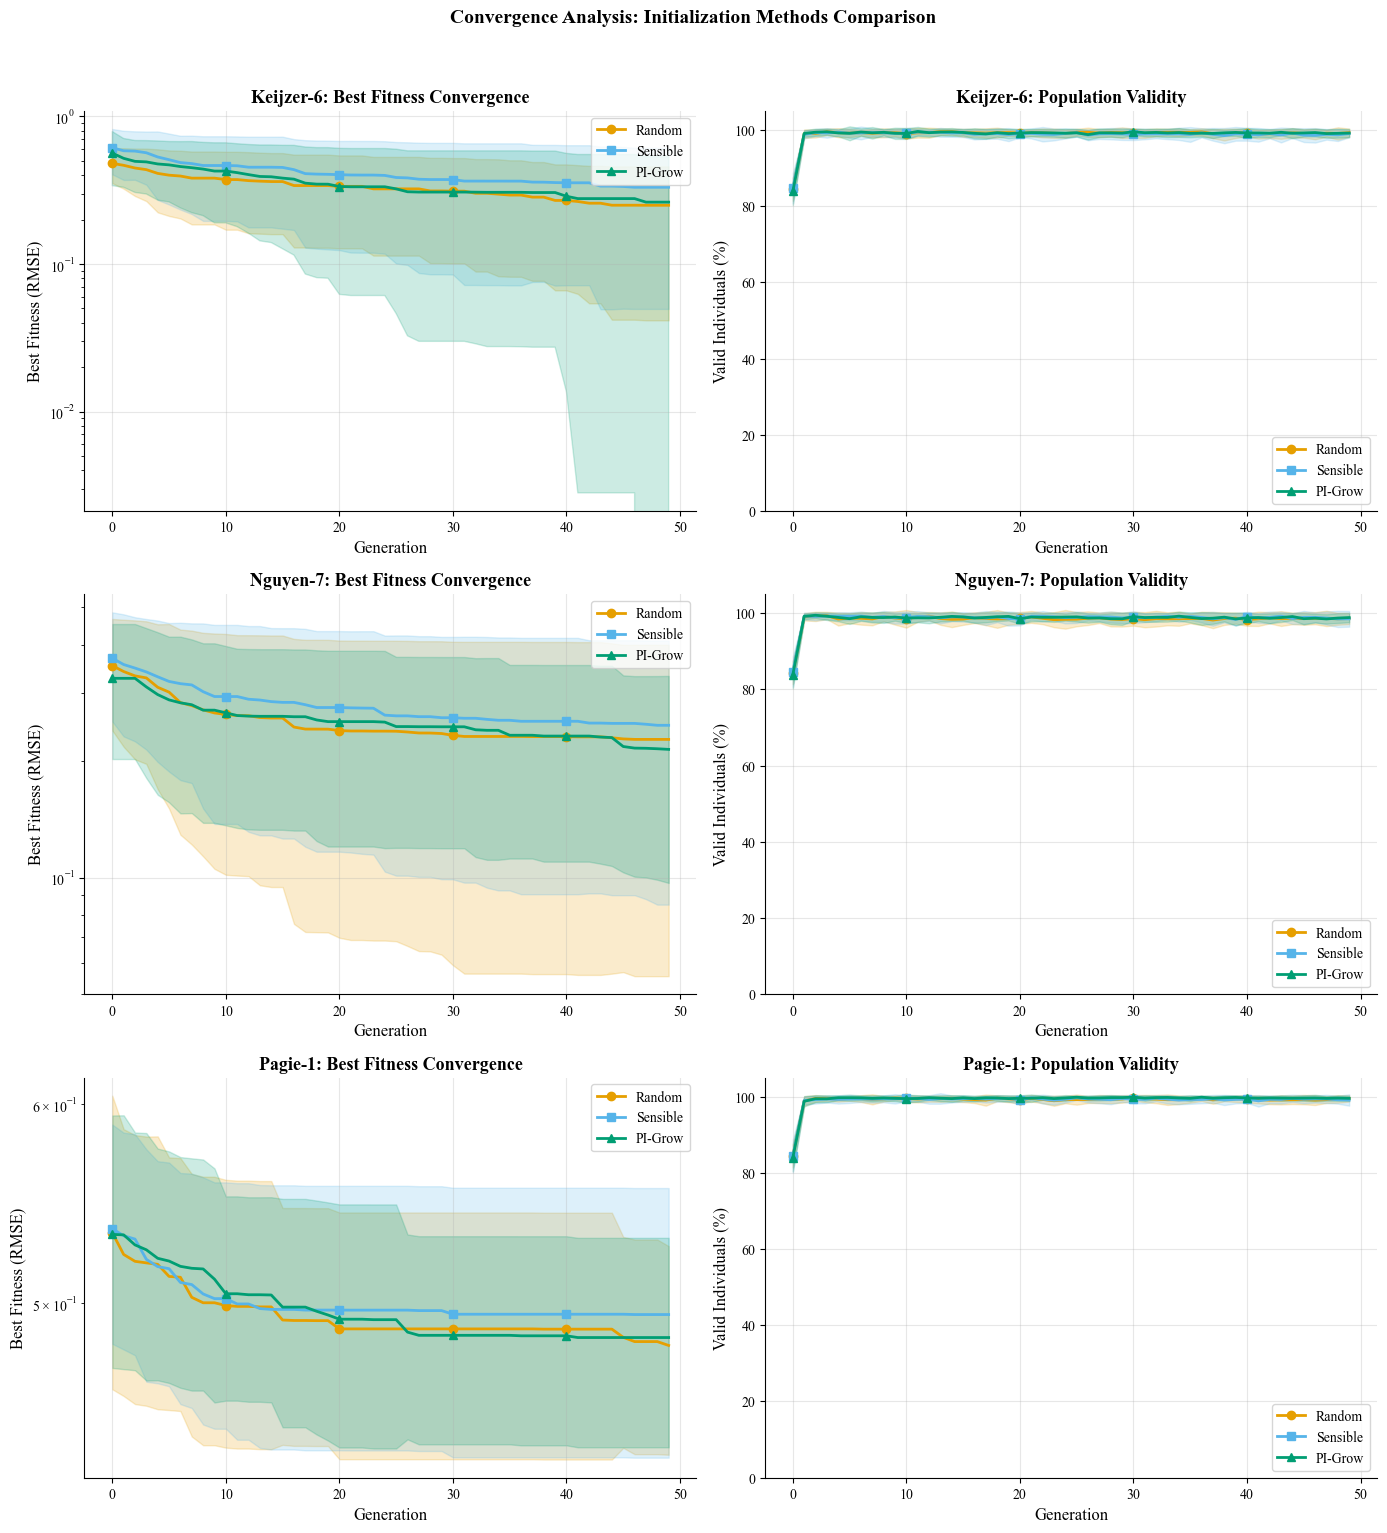

Saved: boxplot_comparison.png


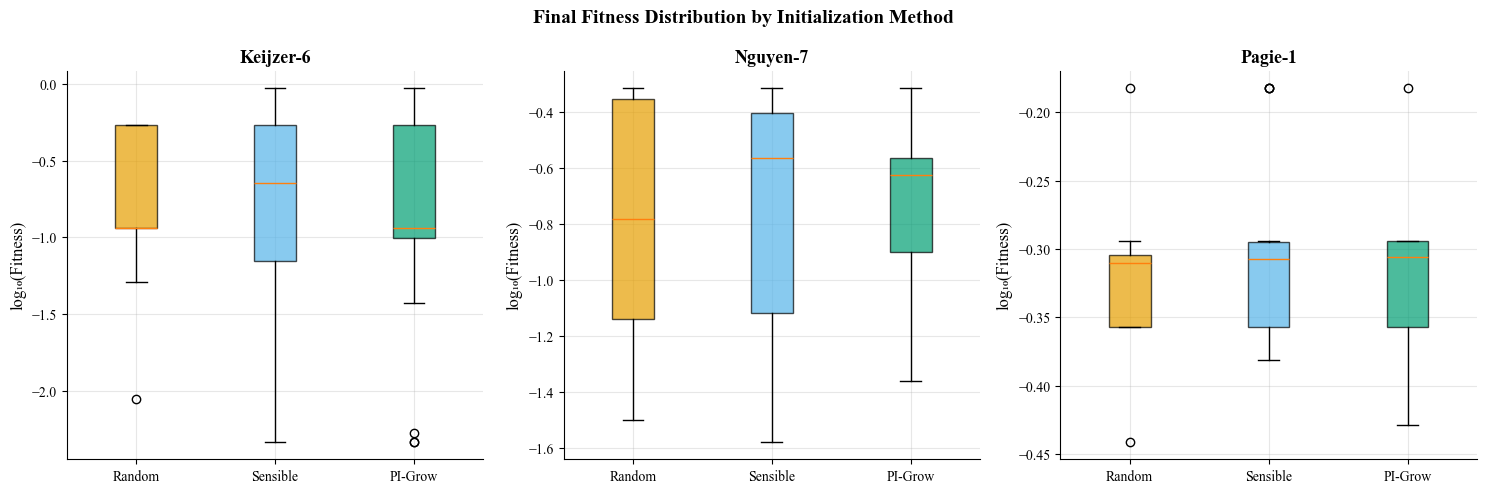

Saved: initialization_analysis.png


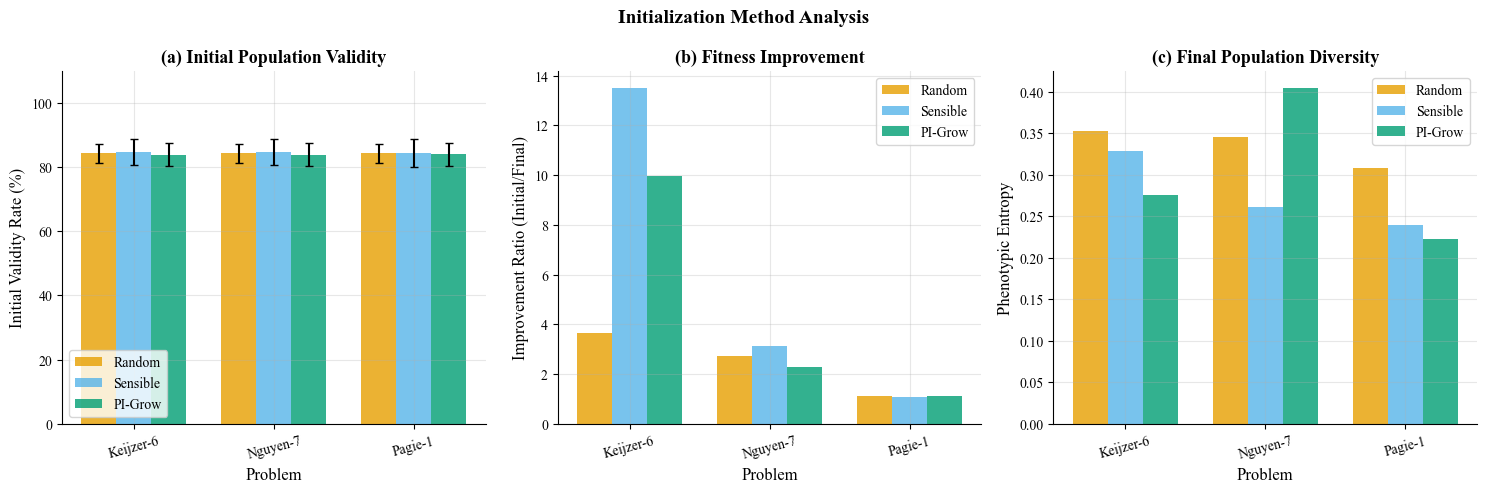

In [22]:
# %%
# =============================================================================
# STATISTICAL ANALYSIS
# =============================================================================

def analyze_results(results: Dict, config: ExperimentConfig = None) -> Dict:
    """
    Perform comprehensive statistical analysis.
    
    Args:
        results: Experiment results dictionary
        config: Experiment configuration
    
    Returns:
        Analysis results dictionary
    """
    if config is None:
        config = CONFIG
    
    print("\n" + "=" * 70)
    print(" STATISTICAL ANALYSIS")
    print("=" * 70)
    
    analysis = {}
    
    for prob_name, prob_results in results.items():
        print(f"\n{'─' * 60}")
        print(f" {prob_name}")
        print(f"{'─' * 60}")
        
        methods = list(prob_results.keys())
        
        # Extract metrics
        train_fitness = {m: [r['train_fitness'] for r in prob_results[m]] for m in methods}
        test_fitness = {m: [r['test_fitness'] for r in prob_results[m]] for m in methods}
        init_validity = {m: [r['statistics'].validity_rate[0] for r in prob_results[m]] for m in methods}
        
        # Summary statistics
        print("\n  Training RMSE:")
        print("  " + "-" * 55)
        print(f"  {'Method':<12} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
        print("  " + "-" * 55)
        
        for method in methods:
            data = train_fitness[method]
            print(f"  {method:<12} {np.mean(data):>10.4f} {np.std(data):>10.4f} "
                  f"{np.min(data):>10.4f} {np.max(data):>10.4f}")
        
        print("\n  Test RMSE:")
        print("  " + "-" * 55)
        print(f"  {'Method':<12} {'Mean':>10} {'Std':>10} {'Min':>10} {'Max':>10}")
        print("  " + "-" * 55)
        
        for method in methods:
            data = [x for x in test_fitness[method] if x < 1e6]
            if data:
                print(f"  {method:<12} {np.mean(data):>10.4f} {np.std(data):>10.4f} "
                      f"{np.min(data):>10.4f} {np.max(data):>10.4f}")
        
        print("\n  Initial Validity Rate:")
        print("  " + "-" * 35)
        for method in methods:
            data = init_validity[method]
            print(f"  {method:<12} {np.mean(data)*100:>8.1f}% ± {np.std(data)*100:.1f}%")
        
        # Statistical tests
        print("\n  Mann-Whitney U Tests (Training RMSE):")
        print("  " + "-" * 55)
        
        comparisons = [('Random', 'Sensible'), ('Random', 'PI-Grow'), ('Sensible', 'PI-Grow')]
        
        for m1, m2 in comparisons:
            stat, p = mannwhitneyu(train_fitness[m1], train_fitness[m2], alternative='two-sided')
            sig = "p<0.05 *" if p < 0.05 else "n.s."
            print(f"  {m1:>10} vs {m2:<10}: U={stat:>6.0f}, p={p:.4f} ({sig})")
        
        # Kruskal-Wallis test
        stat, p = kruskal(*[train_fitness[m] for m in methods])
        print(f"\n  Kruskal-Wallis (all methods): H={stat:.2f}, p={p:.4f}")
        
        analysis[prob_name] = {
            'train_fitness': train_fitness,
            'test_fitness': test_fitness,
            'init_validity': init_validity,
        }
    
    return analysis


analysis = analyze_results(results, CONFIG)

# %% [markdown]
# ## 12. Visualization

# %%
# =============================================================================
# CONVERGENCE PLOTS
# =============================================================================

def plot_convergence(results: Dict, save_path: str = None):
    """
    Plot convergence curves for all problems.
    """
    problems = list(results.keys())
    n_problems = len(problems)
    
    fig, axes = plt.subplots(n_problems, 2, figsize=(14, 5*n_problems))
    if n_problems == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Convergence Analysis: Initialization Methods Comparison',
                 fontsize=14, fontweight='bold', y=1.02)
    
    for idx, prob_name in enumerate(problems):
        prob_results = results[prob_name]
        methods = list(prob_results.keys())
        generations = len(prob_results[methods[0]][0]['statistics'].best_fitness)
        
        # Best Fitness
        ax = axes[idx, 0]
        for method in methods:
            curves = np.array([r['statistics'].best_fitness for r in prob_results[method]])
            mean = np.mean(curves, axis=0)
            std = np.std(curves, axis=0)
            x = np.arange(generations)
            
            ax.plot(x, mean, label=method, color=COLORS[method], 
                   linewidth=2, marker=MARKERS[method], markevery=10, markersize=6)
            ax.fill_between(x, mean - std, mean + std, color=COLORS[method], alpha=0.2)
        
        ax.set_xlabel('Generation')
        ax.set_ylabel('Best Fitness (RMSE)')
        ax.set_title(f'{prob_name}: Best Fitness Convergence')
        ax.legend(loc='upper right')
        ax.set_yscale('log')
        
        # Validity Rate
        ax = axes[idx, 1]
        for method in methods:
            curves = np.array([r['statistics'].validity_rate for r in prob_results[method]])
            mean = np.mean(curves, axis=0) * 100
            std = np.std(curves, axis=0) * 100
            x = np.arange(generations)
            
            ax.plot(x, mean, label=method, color=COLORS[method],
                   linewidth=2, marker=MARKERS[method], markevery=10, markersize=6)
            ax.fill_between(x, mean - std, mean + std, color=COLORS[method], alpha=0.2)
        
        ax.set_xlabel('Generation')
        ax.set_ylabel('Valid Individuals (%)')
        ax.set_title(f'{prob_name}: Population Validity')
        ax.legend(loc='lower right')
        ax.set_ylim([0, 105])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig


fig_conv = plot_convergence(results, 'convergence_plots.png')

# %%
# =============================================================================
# BOXPLOT COMPARISON
# =============================================================================

def plot_boxplots(results: Dict, save_path: str = None):
    """
    Create boxplots comparing final fitness distributions.
    """
    problems = list(results.keys())
    n_problems = len(problems)
    
    fig, axes = plt.subplots(1, n_problems, figsize=(5*n_problems, 5))
    if n_problems == 1:
        axes = [axes]
    
    fig.suptitle('Final Fitness Distribution by Initialization Method',
                 fontsize=14, fontweight='bold')
    
    for idx, prob_name in enumerate(problems):
        prob_results = results[prob_name]
        methods = list(prob_results.keys())
        
        ax = axes[idx]
        
        # Prepare data for boxplot
        box_data = []
        for method in methods:
            fitness_values = [r['train_fitness'] for r in prob_results[method]]
            # Use log scale for better visualization
            box_data.append(np.log10(np.array(fitness_values) + 1e-10))
        
        bp = ax.boxplot(box_data, labels=methods, patch_artist=True)
        
        # Color boxes
        for patch, method in zip(bp['boxes'], methods):
            patch.set_facecolor(COLORS[method])
            patch.set_alpha(0.7)
        
        ax.set_ylabel('log₁₀(Fitness)')
        ax.set_title(prob_name)
        ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig


fig_box = plot_boxplots(results, 'boxplot_comparison.png')

# %%
# =============================================================================
# INITIALIZATION ANALYSIS PLOT
# =============================================================================

def plot_initialization_analysis(results: Dict, save_path: str = None):
    """
    Analyze the impact of initialization methods.
    """
    problems = list(results.keys())
    methods = list(results[problems[0]].keys())
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Initialization Method Analysis',
                 fontsize=14, fontweight='bold')
    
    # (a) Initial Validity Rate
    ax = axes[0]
    x = np.arange(len(problems))
    width = 0.25
    
    for i, method in enumerate(methods):
        validity_means = []
        validity_stds = []
        for prob_name in problems:
            validity = [r['statistics'].validity_rate[0] * 100 
                       for r in results[prob_name][method]]
            validity_means.append(np.mean(validity))
            validity_stds.append(np.std(validity))
        
        ax.bar(x + i*width, validity_means, width, yerr=validity_stds,
               label=method, color=COLORS[method], alpha=0.8, capsize=3)
    
    ax.set_xlabel('Problem')
    ax.set_ylabel('Initial Validity Rate (%)')
    ax.set_title('(a) Initial Population Validity')
    ax.set_xticks(x + width)
    ax.set_xticklabels(problems, rotation=15)
    ax.legend()
    ax.set_ylim([0, 110])
    
    # (b) Improvement Ratio
    ax = axes[1]
    
    for i, method in enumerate(methods):
        improvements = []
        for prob_name in problems:
            initial = [r['statistics'].best_fitness[0] for r in results[prob_name][method]]
            final = [r['train_fitness'] for r in results[prob_name][method]]
            ratios = [i/f if f > 0 else 1 for i, f in zip(initial, final)]
            improvements.append(np.mean(ratios))
        
        ax.bar(x + i*width, improvements, width, 
               label=method, color=COLORS[method], alpha=0.8)
    
    ax.set_xlabel('Problem')
    ax.set_ylabel('Improvement Ratio (Initial/Final)')
    ax.set_title('(b) Fitness Improvement')
    ax.set_xticks(x + width)
    ax.set_xticklabels(problems, rotation=15)
    ax.legend()
    
    # (c) Final Diversity
    ax = axes[2]
    
    for i, method in enumerate(methods):
        diversity_means = []
        for prob_name in problems:
            diversity = [r['statistics'].diversity[-1] for r in results[prob_name][method]]
            diversity_means.append(np.mean(diversity))
        
        ax.bar(x + i*width, diversity_means, width,
               label=method, color=COLORS[method], alpha=0.8)
    
    ax.set_xlabel('Problem')
    ax.set_ylabel('Phenotypic Entropy')
    ax.set_title('(c) Final Population Diversity')
    ax.set_xticks(x + width)
    ax.set_xticklabels(problems, rotation=15)
    ax.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig


fig_init = plot_initialization_analysis(results, 'initialization_analysis.png')

### 13. Best Solutions Summary

In [23]:
# %%
# =============================================================================
# BEST SOLUTIONS SUMMARY
# =============================================================================

def print_best_solutions(results: Dict):
    """
    Print the best solutions found for each problem and method.
    """
    print("\n" + "=" * 70)
    print(" BEST SOLUTIONS FOUND")
    print("=" * 70)
    
    for prob_name, prob_results in results.items():
        print(f"\n{'─' * 60}")
        print(f" {prob_name}")
        print(f"{'─' * 60}")
        
        for method_name, method_runs in prob_results.items():
            best_run = min(method_runs, key=lambda r: r['train_fitness'])
            best = best_run['best_individual']
            
            print(f"\n  {method_name}:")
            print(f"    Train RMSE: {best.fitness:.6f}")
            print(f"    Test RMSE:  {best_run['test_fitness']:.6f}")
            print(f"    Phenotype:  {best.phenotype}")


print_best_solutions(results)


 BEST SOLUTIONS FOUND

────────────────────────────────────────────────────────────
 Keijzer-6
────────────────────────────────────────────────────────────

  Random:
    Train RMSE: 0.008811
    Test RMSE:  0.010102
    Phenotype:  np.log1p((x[:, 0]+(x[:, 0]*np.cos(np.sqrt(0.5)))))

  Sensible:
    Train RMSE: 0.004662
    Test RMSE:  0.004327
    Phenotype:  np.log1p((np.sqrt((np.pi+np.sin(np.pi)))*x[:, 0]))

  PI-Grow:
    Train RMSE: 0.004662
    Test RMSE:  0.004327
    Phenotype:  np.log1p((x[:, 0]*np.sqrt(np.pi)))

────────────────────────────────────────────────────────────
 Nguyen-7
────────────────────────────────────────────────────────────

  Random:
    Train RMSE: 0.031521
    Test RMSE:  0.031603
    Phenotype:  (x[:, 0]+(np.sin(np.log1p(np.sqrt(x[:, 0])))*np.sqrt((np.abs(x[:, 0])-np.log1p(x[:, 0])))))

  Sensible:
    Train RMSE: 0.026366
    Test RMSE:  0.029172
    Phenotype:  (x[:, 0]+(np.abs(np.abs(np.log1p(x[:, 0])))*(np.sqrt(np.sqrt(x[:, 0]))-0.5)))

  PI-Grow:
 

### 14. Summary Table

In [25]:
# %%
# =============================================================================
# SUMMARY TABLE FOR PUBLICATION
# =============================================================================

def create_summary_table(results: Dict):
    """
    Create a publication-ready summary table.
    """
    print("\n" + "=" * 70)
    print(" SUMMARY TABLE")
    print("=" * 70)
    
    print("\nTable: Mean ± Std of Training RMSE across 30 runs")
    print("-" * 70)
    
    header = f"{'Problem':<15}"
    methods = list(results[list(results.keys())[0]].keys())
    for method in methods:
        header += f" {method:>16}"
    print(header)
    print("-" * 70)
    
    for prob_name, prob_results in results.items():
        row = f"{prob_name:<15}"
        for method in methods:
            fitness_values = [r['train_fitness'] for r in prob_results[method]]
            mean = np.mean(fitness_values)
            std = np.std(fitness_values)
            row += f" {mean:>7.4f}±{std:<7.4f}"
        print(row)
    
    print("-" * 70)
    
    # Ranking
    print("\nMethod Rankings (by mean training RMSE, lower is better):")
    print("-" * 50)
    
    for prob_name, prob_results in results.items():
        means = {}
        for method in methods:
            fitness_values = [r['train_fitness'] for r in prob_results[method]]
            means[method] = np.mean(fitness_values)
        
        ranked = sorted(means.items(), key=lambda x: x[1])
        rank_str = ", ".join([f"{i+1}.{m}" for i, (m, _) in enumerate(ranked)])
        print(f"  {prob_name:<15}: {rank_str}")


create_summary_table(results)



 SUMMARY TABLE

Table: Mean ± Std of Training RMSE across 30 runs
----------------------------------------------------------------------
Problem                   Random         Sensible          PI-Grow
----------------------------------------------------------------------
Keijzer-6        0.2500±0.2085   0.3312±0.2816   0.2626±0.2720 
Nguyen-7         0.2277±0.1721   0.2476±0.1625   0.2137±0.1181 
Pagie-1          0.4809±0.0459   0.4947±0.0609   0.4844±0.0464 
----------------------------------------------------------------------

Method Rankings (by mean training RMSE, lower is better):
--------------------------------------------------
  Keijzer-6      : 1.Random, 2.PI-Grow, 3.Sensible
  Nguyen-7       : 1.PI-Grow, 2.Random, 3.Sensible
  Pagie-1        : 1.Random, 2.PI-Grow, 3.Sensible
